# **Part 3 - Data Cleaning**

## Objectives

* Evalutate any missing data levels and decide how to handle
* Clean data ready for feature engineering and ML development

## Inputs

* Raw Dataset: inputs/datasets/raw-heritage-housing

## Outputs

* Clean Train and Test sets saved under outputs/datasets/clean


---

# Change working directory

* As the notebooks are stored in a subfolder, when running the notebook in the editor, the working directory will need to be adjusted.

The working directory will be changed from its current folder to its parent folder
* access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Project5-PredictiveAnalytics-HeritageHousing/jupyter_notebooks'

The parent of the current directory needs to be made the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


* Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Project5-PredictiveAnalytics-HeritageHousing'

<hr>

## Data Loading 

### Load Data

In [4]:
import pandas as pd
heritage_housing = pd.read_csv('./inputs/datasets/raw-heritage-housing/house-price-20211124T154130Z-001/house-price/house_prices_records.csv')
heritage_housing.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


## Data Exploration

The focus of data cleaning should start with some exploration of the data, we will begin by assessing missing data levels within the dataset. We will start by examining distribution levels and shapes of the variables with missing data

In [5]:
missing_data_variables = heritage_housing.columns[heritage_housing.isna().sum() > 0].to_list()
missing_data_variables

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [6]:
from ydata_profiling import ProfileReport
if missing_data_variables:
    report = ProfileReport(df=heritage_housing[missing_data_variables], minimal=True)
    report.to_notebook_iframe()
else:
    print('There are no variables with missing data')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Correlation & Predictive Power Score Analysis

Next we will analyse the correlation and predictive power score of the variables. We will use the custom code generated within the Churnometer walkthrough project, the functions generate scores for the correlation and PPS scores using the Pearson and Spearman methods, and also generates heatmaps for both methods.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
%matplotlib inline

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='jet', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rainbow', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Using these custom functions we can calculate the correlation levels and the predictive power score for our data

In [8]:
heritage_corr_pearson, heritage_corr_spearman, pps_matrix = CalculateCorrAndPPS(heritage_housing)


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



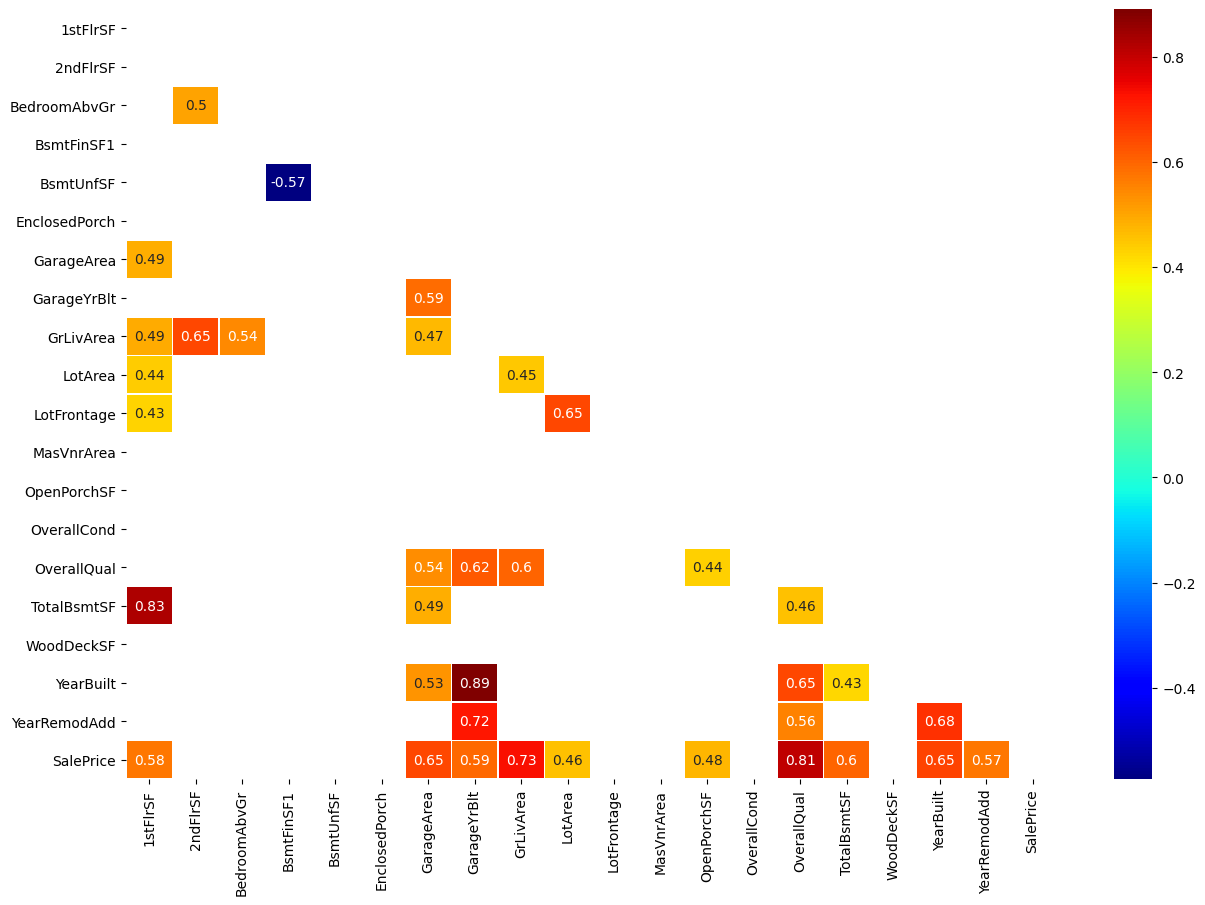



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



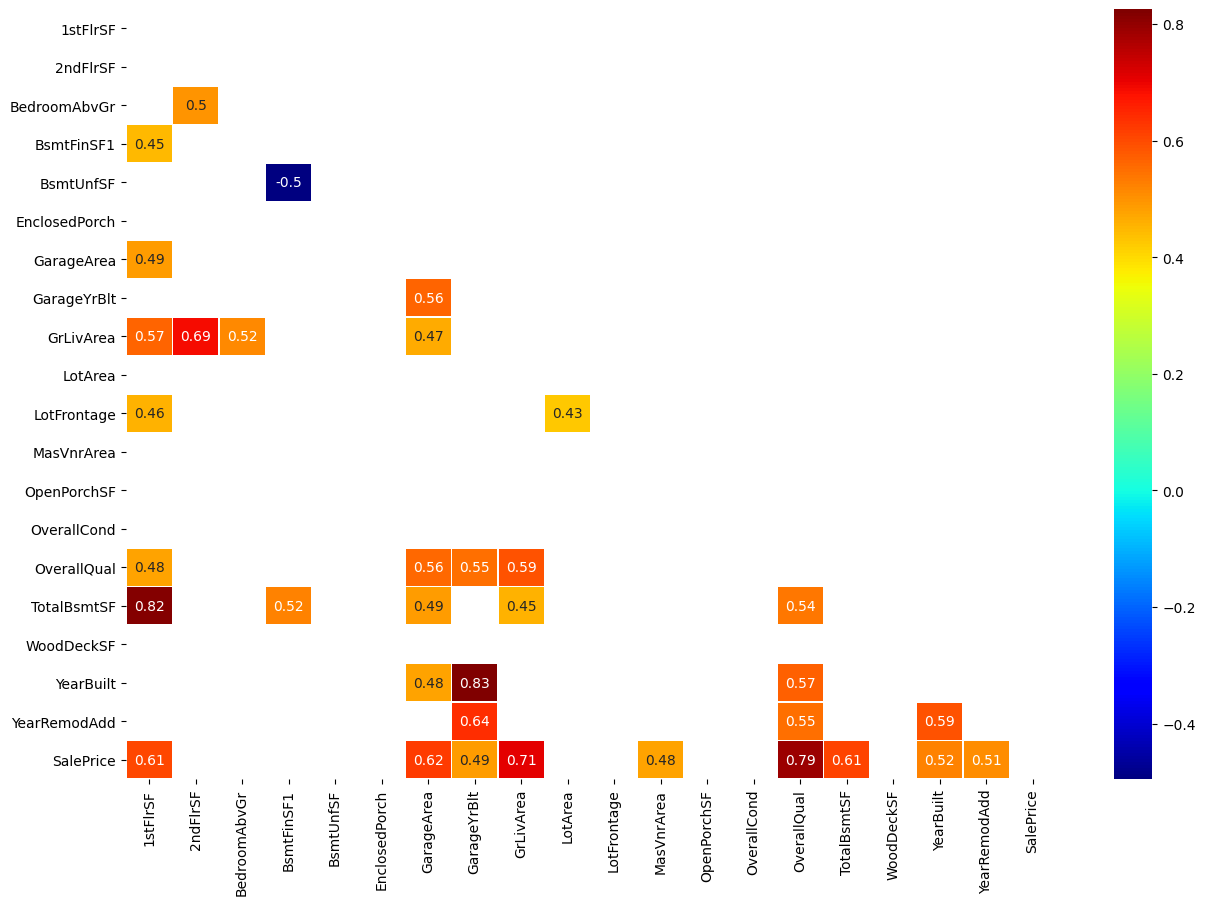



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



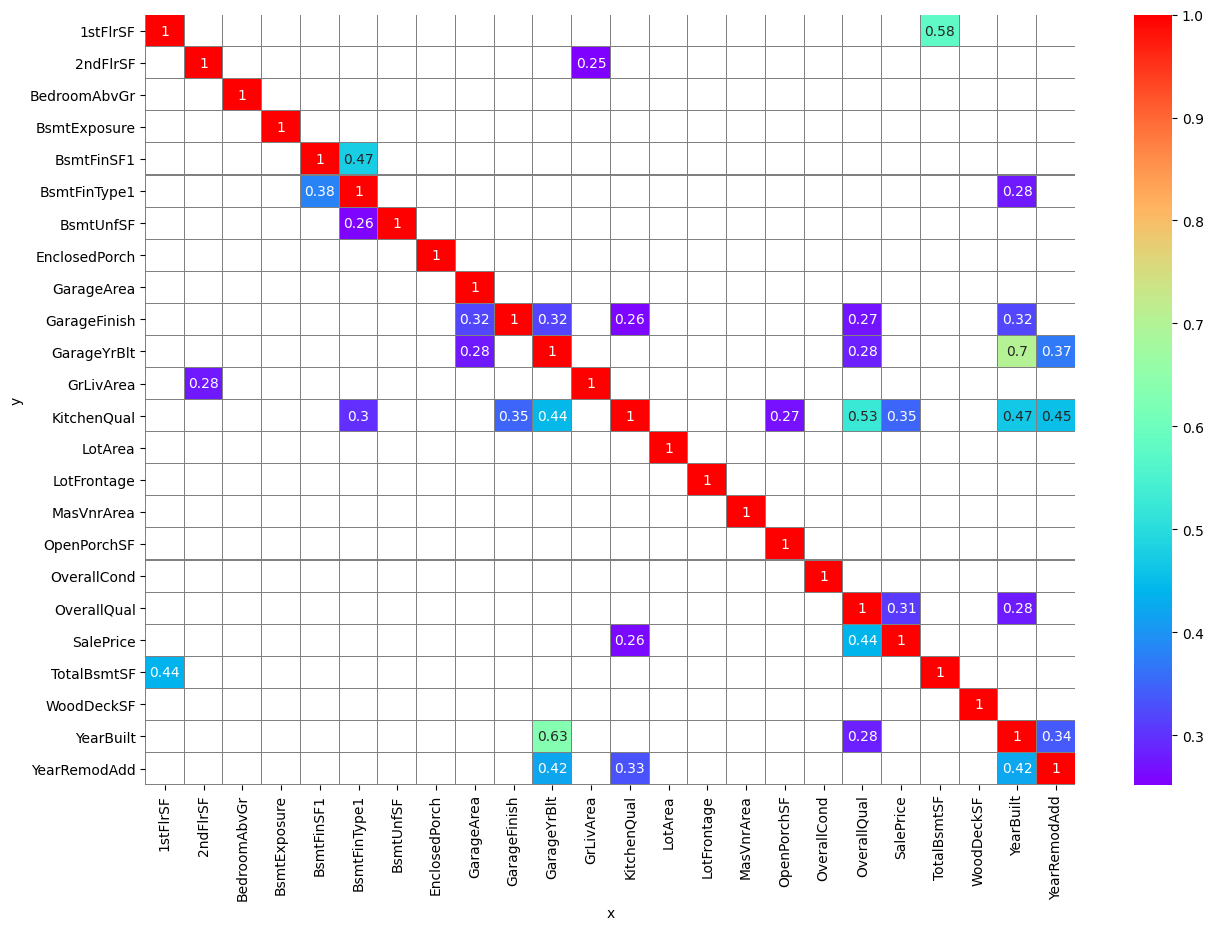

In [9]:
DisplayCorrAndPPS(df_corr_pearson = heritage_corr_pearson, 
                  df_corr_spearman = heritage_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.425, PPS_Threshold = 0.25,
                  figsize = (15, 10), font_annot=10)

---

## Data Cleaning

Evaluating missing data levels is our next step so we can address how to handle them, we use a custom function to check absolute levels and percentages for the missing data & their types.

In [10]:
def MissingDataLevels(df):
    absolute_missing = df.isnull().sum()
    percentage_missing = round(absolute_missing/len(df)*100, 2)
    missing_dataframe = (pd.DataFrame(
        data = {'Rows with missing values': absolute_missing,
                'Percentage of Data': percentage_missing,
                'Data Types': df.dtypes})
                .sort_values(by=['Percentage of Data'], ascending=False)
                .query("`Percentage of Data` > 0")
    )

    return missing_dataframe

Next we will run this function on our collected raw dataset. 

In [11]:
MissingDataLevels(heritage_housing)

,Rows with missing values,Percentage of Data,Data Types
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


### Missing Data Analysis

As many machine learning algorithms will fail when faced with missing values, we will investigate several potential transformers to address these features that are missing and identify the best possible imputer solution to use. The table beneath shows our final decisions with a more detailed explanation below.

| Variable | Missing Value Row Count | % Total of Data | DTypes | Potential Imputer Approach |
| --- | --- | --- | --- | --- |
| EnclosedPorch | 1324 |  90.68 |  float64 | Arbitrary Number | 
| WoodDeckSF | 1305 | 89.38 | float64 | Arbitray Number |
| LotFrontage | 259 | 17.74 | float64 | Mean Median |
| GarageFinish | 162 | 11.10 | object | Categorical Variable |
| BsmtFinType1 | 114 | 7.81 | object | Categorical Variable | 
| BedroomAbvGr | 99 | 6.78 | float64 | Mean Median | 
| 2ndFlrSF | 86 | 5.89 | float64 | Arbitrary Number | 
| GarageYrBlt | 81 | 5.55 | float64 | Mean Median |
| MasVnrArea | 8 | 0.55 | float 64 | Arbitrary Number |

### Arbitrary Number Imputer

We can clearly see in our table that the two features that have the highest percentage of missing values are <code>EnclosedPorch</code> & <code>WoodDeckSF</code>. It is not unreasonable to assume that as they are both contain over 80% of missing data that we would drop the columns as we did during our study on <code>SalePrice</code>, however it is always as a last resort. 

When we examine the YDataProfiling report we can see that the majority of the available values for <code>EnclosedPorch</code>, <code>WoodDeckSF</code>, <code>2ndFlrSF</code>, <code>MasVnrArea</code> are 0 anyway. So it would make sense that we can replace the missing values of these Features with our arbitrary number of 0 without affecting the integrity of our data or performance of our ML model while being able to avoid dropping any of the data.

### Mean Median Imputer

Firstly we will examine the numerical features that would be unsuitable for using an arbitrary number to populate the missing values, we will start with <code>GarageYrBlt</code>. 

In [12]:
heritage_garages_missing = heritage_housing[heritage_housing['GarageYrBlt'].isna()]
heritage_garages_missing[['GarageArea', 'GarageFinish', 'GarageYrBlt']]

,GarageArea,GarageFinish,GarageYrBlt
39,0,None,NaN
48,0,None,NaN
78,0,None,NaN
88,0,None,NaN
89,0,None,NaN
...,...,...,...
1349,0,None,NaN
1407,0,None,NaN
1449,0,None,NaN
1450,0,None,NaN


We can see from examining the list that the high majority of missing values for this feature are strongly indicative that the house doesn't have a garage, so we can fill the missing values using MeanMedianImputer. We can see from the correlation level heatmaps that while <code>GarageYrBlt</code> is correlated with <code>SalePrice</code>, <code>GarageArea</code> is more positively correlated so that should take precedence when fitting the model.

Next we will examine <code>BedroomAbvGr</code>. As the number of bedrooms can have an effect on <code>SalePrice</code> it is prudent to fill the values also using the MeanMedianImputer to generate an average. It is worth noting that with more time and resources it could be possible to more accurately investigate the number of bedrooms based on other factors such as the size of the first and second floors, as an argument could be made that the larger the size of the house, the more likely it would be to have a higher number of bedrooms. 

The next feature we will look at is <code>LotFrontage</code>, it would be most prudent to use the average value to fill the data without affecting our ML performance severely as there is minimal correlation between this feature & our target <code>SalePrice</code>.

### Categorical Variable Imputer

Firstly when considering our two object data type features, we will look at the <code>GarageFinish</code>. As shown in our correlation study and heatmaps, there is minimal correlation between this feature and our target <code>SalePrice</code>. However unlike to our investigation into <code>GarageYrBlt</code> we can see when we examine the values that the other features are strongly indicative that the houses do have a garage.

In [13]:
heritage_garage_finish_missing = heritage_housing[heritage_housing['GarageFinish'].isna()]
heritage_garage_finish_missing[['GarageArea', 'GarageFinish', 'GarageYrBlt']]

,GarageArea,GarageFinish,GarageYrBlt
7,484,NaN,1973.0
12,352,NaN,1962.0
23,572,NaN,1976.0
27,772,NaN,2008.0
35,691,NaN,2004.0
...,...,...,...
1401,398,NaN,2004.0
1415,660,NaN,2007.0
1438,923,NaN,1957.0
1442,812,NaN,2008.0


However we have no indication of the quality of the finish of the garages. Similar to the discussion in our <code>BedroomAbvGr</code> examination, it could be possible with further time and resources to conduct a more detailed investigation into <code>GarageFinish</code> based on the other features shown in in the PPS heatmap such as <code>OverallQual</code>, <code>GarageYrBlt</code>, <code>KitchenQual</code>, <code>GarageArea</code> and <code>YearBlt</code>. 

But in this circumstance we will fill the value with <code>Unf</code> as although the <code>GarageFinish</code> feature has minimal correlation with <code>SalePrice</code> our selected value should have the least impact on the integrity of our data.

Our final feature we will examine is the <code>BsmtFinType1</code>

In [14]:
heritage_bsmt_missing = heritage_housing[heritage_housing['BsmtFinType1'].isna()]
heritage_bsmt_missing[['BsmtFinType1', 'BsmtUnfSF', 'BsmtFinSF1', 'TotalBsmtSF']]

,BsmtFinType1,BsmtUnfSF,BsmtFinSF1,TotalBsmtSF
11,NaN,177,998,1175
22,NaN,1777,0,1777
26,NaN,180,234,900
55,NaN,935,490,1425
89,NaN,402,588,990
...,...,...,...,...
1415,NaN,398,988,1386
1423,NaN,697,0,697
1435,NaN,1319,0,1319
1446,NaN,595,593,1188


When we view the missing values against the other relevant Basement features we can see that the majority have unfinished square footage of Basement Area. There are a small number of records that have a finished Basement however this number is neglible, and again with more time and resources we could investigate this further to decide on an appropriate value. But in this instance the safest way to deal with these values is use the same value of <code>Unf</code> as we did when examining <code>GarageFinish</code>

### Cleaning Functions

Now we are going to implement our chosen transformers to fill the missing data then assess the effect this has had, by comparing the original data with the clean data. So first we will select each imputation as outlined in the discussion above, and apply them to the features we discussed. 

* First we import our transformers

In [15]:
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer, ArbitraryNumberImputer

* Second, we define our features grouped by the transformers we have specified

In [16]:
# Categorical 
categorical_features = ['GarageFinish', 'BsmtFinType1'] 

# Arbitrary
arbitrary_num_features = ['EnclosedPorch', 'WoodDeckSF', '2ndFlrSF', 'MasVnrArea']

# MeanMeadian
mean_med_features = ['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt']

* Next we call the Transformers and create new DataFrames to apply each of them

In [17]:
# Categorical
# Call the imputer method
categorical_imputer = CategoricalImputer(imputation_method='missing', 
                                         fill_value='Unf',
                                         variables=categorical_features)
# Generate new dataframe to apply method
categorical_clean = categorical_imputer.fit_transform(heritage_housing)

# Arbitrary
arbitrary_imputer = ArbitraryNumberImputer(arbitrary_number=0,
                                           variables=arbitrary_num_features)
# Generate new dataframe to apply method
arbitrary_clean = arbitrary_imputer.fit_transform(heritage_housing)

# MeanMedian
mean_med_imputer = MeanMedianImputer(imputation_method='median',
                                     variables=mean_med_features)
# Generate new dataframe to apply method
mean_med_clean = mean_med_imputer.fit_transform(heritage_housing)

* Next we will generate a custom function as described in the CodeInstiture course material (*FeatureEngine Unit 9: Custom Functions*) to generate visualisations to compare the effect cleaning the data has had on the distribution

In [18]:
def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate plot number
  
  # distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over variables, 
    # first on variables that you applied the method
    # if the variable is a numerical plot, a histogram if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#840032',"#002642"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#002642", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#840032", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

* Now call the custom function on our data for each of the transformations

### Categorical


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['GarageFinish', 'BsmtFinType1'] 




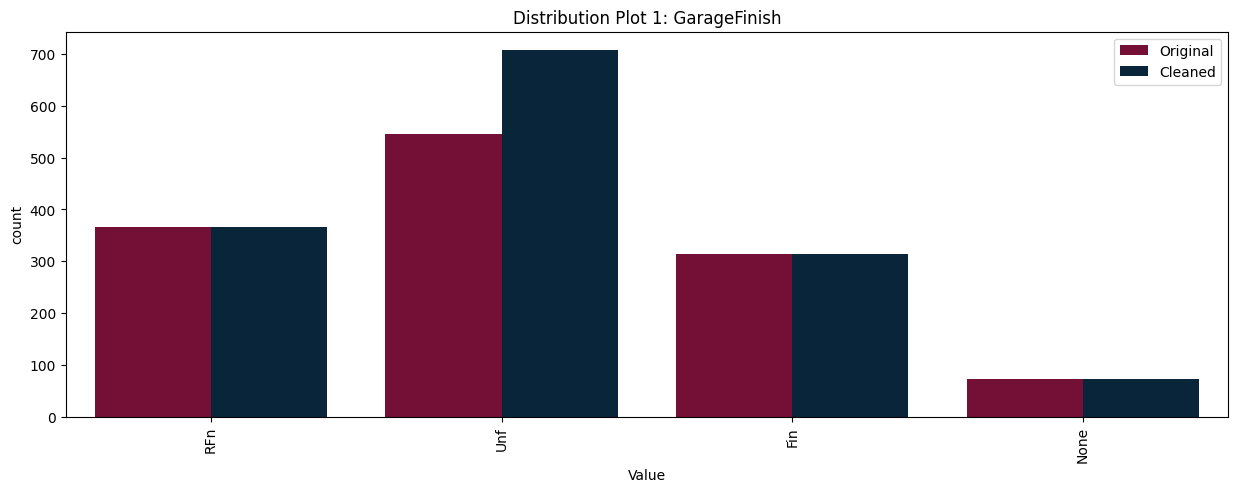

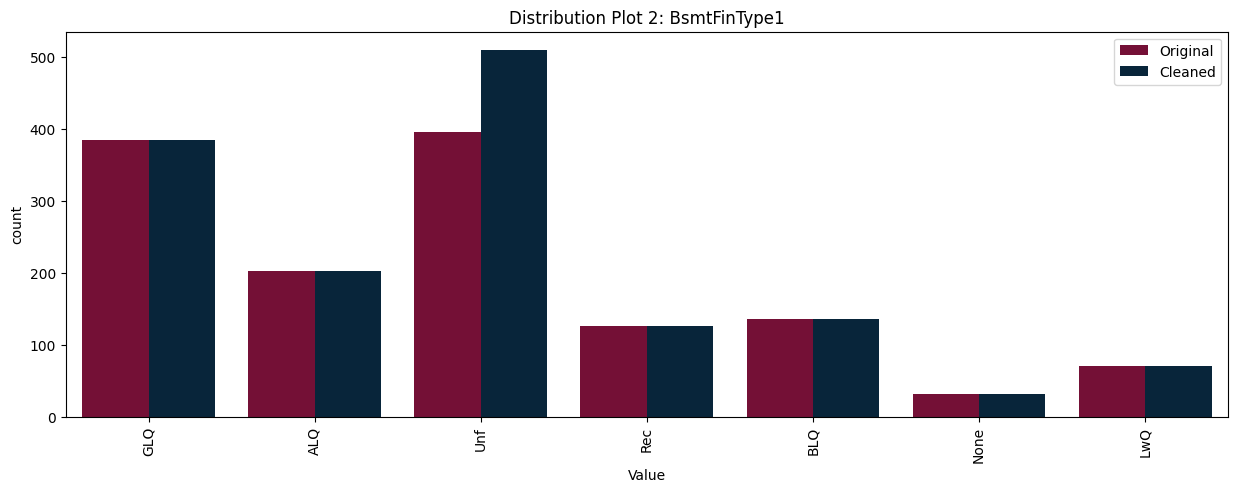

In [19]:
DataCleaningEffect(df_original=heritage_housing,
                   df_cleaned=categorical_clean,
                   variables_applied_with_method=categorical_features)

### Arbitrary


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['EnclosedPorch', 'WoodDeckSF', '2ndFlrSF', 'MasVnrArea'] 




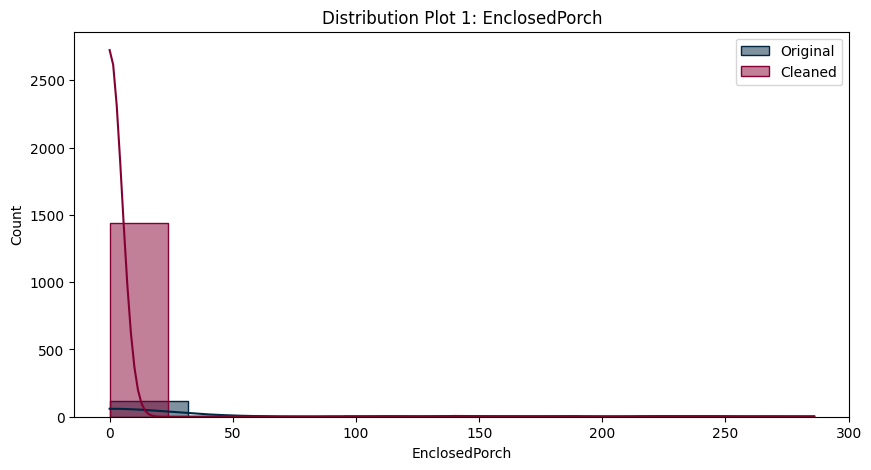

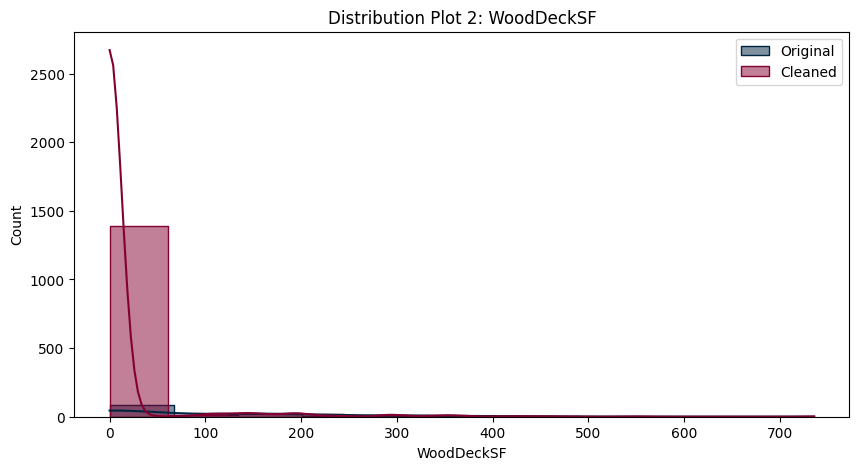

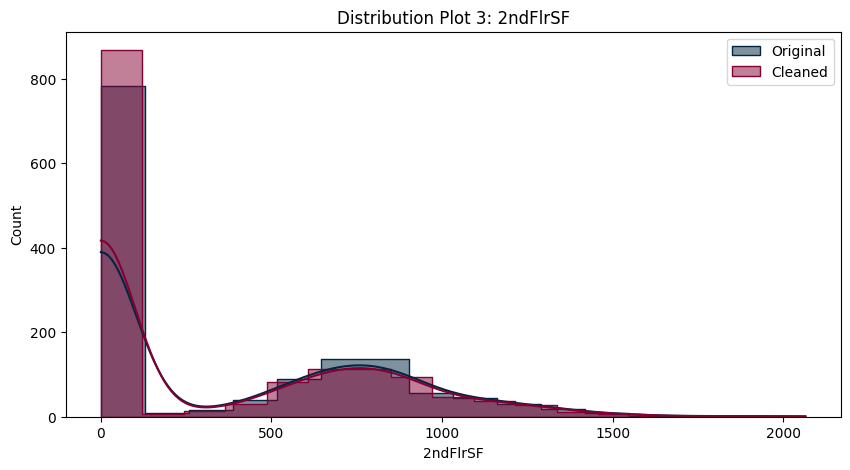

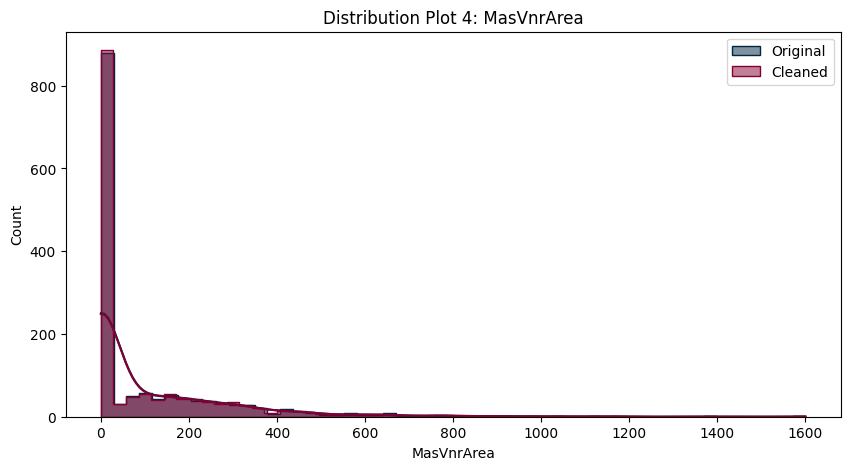

In [20]:
DataCleaningEffect(df_original=heritage_housing,
                   df_cleaned=arbitrary_clean,
                   variables_applied_with_method=arbitrary_num_features)

### MeanMedian


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'] 




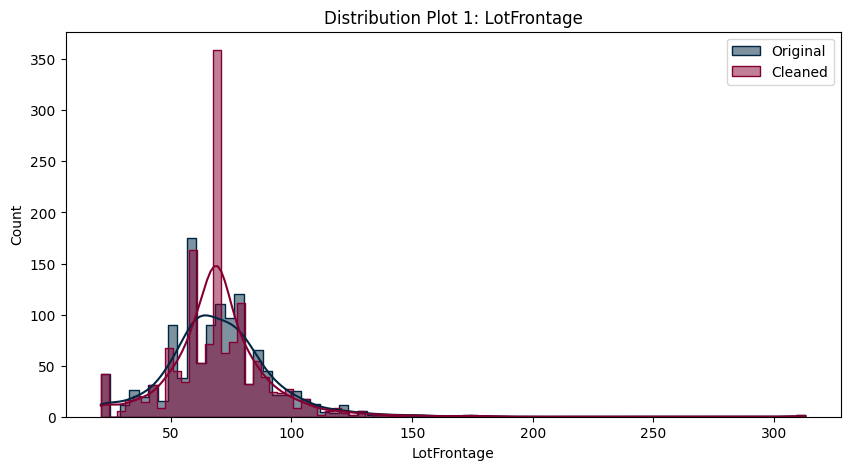

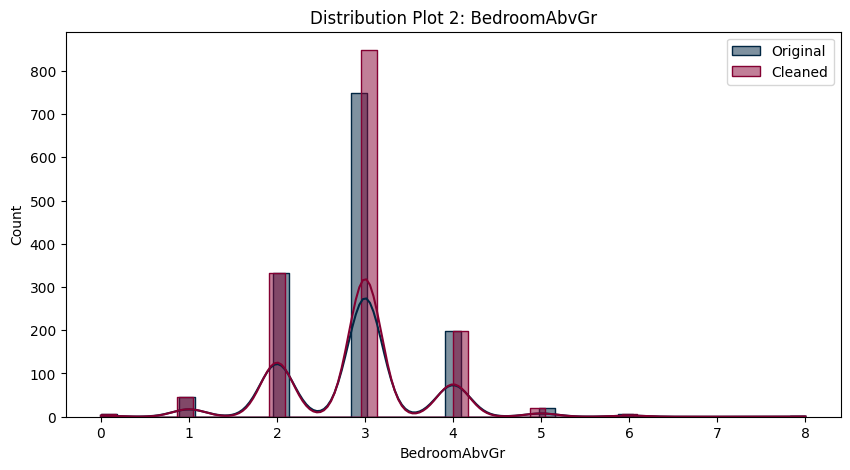

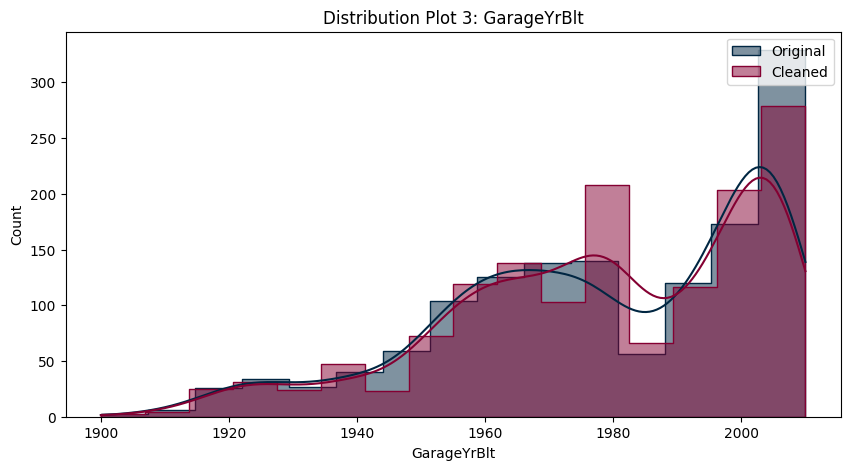

In [21]:
DataCleaningEffect(df_original=heritage_housing,
                   df_cleaned=mean_med_clean,
                   variables_applied_with_method=mean_med_features)

Now we are satisfied with our conclusions & chosen transformers we can move on to applying them to our data using Sci-Kit Learn's <code>Pipeline</code>

---

## Data Cleaning Pipeline

During our analysis, it is important to noe that we didnt impute any data to the the original DataFrame, but instead examined the affect each chosen imputer would affect our data. 

Now we will generate a quick data cleaning pipeline to apply all our chosen transformers to our data set ready to be split into train and test sets. we start by importing the required package.

In [22]:
from sklearn.pipeline import Pipeline

lets just check the original dataset again

In [23]:
heritage_housing.isna().sum()

1stFlrSF            0
2ndFlrSF           86
BedroomAbvGr       99
BsmtExposure        0
BsmtFinSF1          0
BsmtFinType1      114
BsmtUnfSF           0
EnclosedPorch    1324
GarageArea          0
GarageFinish      162
GarageYrBlt        81
GrLivArea           0
KitchenQual         0
LotArea             0
LotFrontage       259
MasVnrArea          8
OpenPorchSF         0
OverallCond         0
OverallQual         0
TotalBsmtSF         0
WoodDeckSF       1305
YearBuilt           0
YearRemodAdd        0
SalePrice           0
dtype: int64

Now we create the pipeline and adding in each imputer as our sequential data cleaning steps and fit the pipeline to our data.

In [24]:
data_cleaning_pipeline = Pipeline([
    ( 'ArbitraryNumberImputer', ArbitraryNumberImputer(arbitrary_number=0,
                                                       variables=arbitrary_num_features)),
    ( 'CategoricalImputer', CategoricalImputer(imputation_method='missing', 
                                               fill_value='Unf',
                                               variables=categorical_features)),
    ( 'MeanMedianImputer', MeanMedianImputer(imputation_method='median',
                                             variables=mean_med_features))
])

In [25]:
heritage_housing = data_cleaning_pipeline.fit_transform(heritage_housing)

Now lets check our data again

In [26]:
heritage_housing.isna().sum()

1stFlrSF         0
2ndFlrSF         0
BedroomAbvGr     0
BsmtExposure     0
BsmtFinSF1       0
BsmtFinType1     0
BsmtUnfSF        0
EnclosedPorch    0
GarageArea       0
GarageFinish     0
GarageYrBlt      0
GrLivArea        0
KitchenQual      0
LotArea          0
LotFrontage      0
MasVnrArea       0
OpenPorchSF      0
OverallCond      0
OverallQual      0
TotalBsmtSF      0
WoodDeckSF       0
YearBuilt        0
YearRemodAdd     0
SalePrice        0
dtype: int64

### Test Train Split

Now we can move on to spliting our data into Train and Test Sets to be used in our feature engineering stage, first we will need to import the <code>train_test_split</code> from Sci-Kit Learn's <code>model_selection</code> package

In [27]:
from sklearn.model_selection import train_test_split

Now we can call the function on our data, although there are a few important points to consider

* Most importantly its critical in ML projects to specify <code>RandomState</code> that will be kept constant across the project. This is to be able to provide reproducibility across the project.
* Then our first two attributes that we pass to the <code>train_test_split</code> are our features and target respectively. The features take the data with <code>SalePrice</code> dropped, then the target subsets the <code>SalePrice</code>

In [28]:
X_train, X_test, y_train, y_test = train_test_split(heritage_housing.drop(['SalePrice'], axis=1),
                                                    heritage_housing['SalePrice'],
                                                    test_size=0.2,
                                                    random_state=2302)

print(f"Train Set: {X_train.shape}, {y_train.shape} \nTest Set: {X_test.shape}, {y_test.shape}")

Train Set: (1168, 23), (1168,) 
Test Set: (292, 23), (292,)


---

# Save Outputs

In [29]:
import os
try:
  os.makedirs(name='outputs/datasets/clean')
except Exception as e:
  print(e)


[Errno 17] File exists: 'outputs/datasets/clean'


### Train Set

In [30]:
X_train.to_csv('outputs/datasets/clean/X_train.csv', index=False)
y_train.to_csv('outputs/datasets/clean/y_train.csv', index=False)

### Test Set

In [31]:
X_test.to_csv('outputs/datasets/clean/X_test.csv', index=False)
y_test.to_csv('outputs/datasets/clean/y_test.csv', index=False)

Now we have our clean data we can move on to the feature engineering step of our workflow